In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 32038 
    Total predicted counts          : 31707.13
    Total off counts                : 102217.00

    Total background counts         : 20443.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.87 s, sys: 7.82 ms, total: 2.88 s
Wall time: 2.88 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 31602 
    Total predicted counts          : 31630.33
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 31506 
    Total predicted counts          : 31662.13
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 31565 
    Total predicted counts          : 31582.93
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_20 

    Total counts                    : 31719 
    Total predicted counts          : 31470.33
    Total off counts                : 101033.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_41 

    Total counts                    : 31234 
    Total predicted counts          : 31565.73
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_42 

    Total counts                    : 31401 
    Total predicted counts          : 31509.53
    Total off counts                : 101229.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_63 

    Total counts                    : 31463 
    Total predicted counts          : 31557.93
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 31445 
    Total predicted counts          : 31522.53
    Total off counts                : 101294.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_85 

    Total counts                    : 31429 
    Total predicted counts          : 31580.13
    Total off counts                : 101582.00

    Total background counts         : 20316.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 31180 
    Total predicted counts          : 31459.13
    Total off counts                : 100977.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_107 

    Total counts                    : 31727 
    Total predicted counts          : 31657.73
    Total off counts                : 101970.00

    Total background counts         : 20394.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_108 

    Total counts                    : 31456 
    Total predicted counts          : 31544.33
    Total off counts                : 101403.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 31571 
    Total predicted counts          : 31523.33
    Total off counts                : 101298.00

    Total background counts         : 20259.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_130 

    Total counts                    : 31577 
    Total predicted counts          : 31499.33
    Total off counts                : 101178.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_151 

    Total counts                    : 31734 
    Total predicted counts          : 31577.53
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_152 

    Total counts                    : 31648 
    Total predicted counts          : 31620.13
    Total off counts                : 101782.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_170 

    Total counts                    : 31489 
    Total predicted counts          : 31639.33
    Total off counts                : 101878.00

    Total background counts         : 20375.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_171 

    Total counts                    : 31423 
    Total predicted counts          : 31587.93
    Total off counts                : 101621.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_191 

    Total counts                    : 31340 
    Total predicted counts          : 31516.13
    Total off counts                : 101262.00

    Total background counts         : 20252.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_192 

    Total counts                    : 31563 
    Total predicted counts          : 31658.53
    Total off counts                : 101974.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_212 

    Total counts                    : 31082 
    Total predicted counts          : 31602.13
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_213 

    Total counts                    : 31519 
    Total predicted counts          : 31634.73
    Total off counts                : 101855.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_234 

    Total counts                    : 31584 
    Total predicted counts          : 31676.93
    Total off counts                : 102066.00

    Total background counts         : 20413.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_235 

    Total counts                    : 31481 
    Total predicted counts          : 31459.13
    Total off counts                : 100977.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_256 

    Total counts                    : 31354 
    Total predicted counts          : 31715.33
    Total off counts                : 102258.00

    Total background counts         : 20451.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_257 

    Total counts                    : 31850 
    Total predicted counts          : 31644.73
    Total off counts                : 101905.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_278 

    Total counts                    : 31809 
    Total predicted counts          : 31727.73
    Total off counts                : 102320.00

    Total background counts         : 20464.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_279 

    Total counts                    : 31594 
    Total predicted counts          : 31696.13
    Total off counts                : 102162.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_300 

    Total counts                    : 31416 
    Total predicted counts          : 31452.73
    Total off counts                : 100945.00

    Total background counts         : 20189.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_301 

    Total counts                    : 31612 
    Total predicted counts          : 31576.53
    Total off counts                : 101564.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_322 

    Total counts                    : 31164 
    Total predicted counts          : 31737.33
    Total off counts                : 102368.00

    Total background counts         : 20473.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 31703 
    Total predicted counts          : 31517.73
    Total off counts                : 101270.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 31562 
    Total predicted counts          : 31502.33
    Total off counts                : 101193.00

    Total background counts         : 20238.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_345 

    Total counts                    : 31429 
    Total predicted counts          : 31512.73
    Total off counts                : 101245.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_365 

    Total counts                    : 31710 
    Total predicted counts          : 31641.13
    Total off counts                : 101887.00

    Total background counts         : 20377.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_366 

    Total counts                    : 31710 
    Total predicted counts          : 31590.33
    Total off counts                : 101633.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_386 

    Total counts                    : 31577 
    Total predicted counts          : 31572.73
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_387 

    Total counts                    : 31482 
    Total predicted counts          : 31557.73
    Total off counts                : 101470.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_408 

    Total counts                    : 31693 
    Total predicted counts          : 31579.93
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 31554 
    Total predicted counts          : 31519.73
    Total off counts                : 101280.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_430 

    Total counts                    : 31513 
    Total predicted counts          : 31603.13
    Total off counts                : 101697.00

    Total background counts         : 20339.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_431 

    Total counts                    : 31426 
    Total predicted counts          : 31645.53
    Total off counts                : 101909.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_452 

    Total counts                    : 31472 
    Total predicted counts          : 31589.53
    Total off counts                : 101629.00

    Total background counts         : 20325.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 31736 
    Total predicted counts          : 31642.53
    Total off counts                : 101894.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 31897 
    Total predicted counts          : 31628.93
    Total off counts                : 101826.00

    Total background counts         : 20365.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_475 

    Total counts                    : 31732 
    Total predicted counts          : 31500.13
    Total off counts                : 101182.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 31538 
    Total predicted counts          : 31604.93
    Total off counts                : 101706.00

    Total background counts         : 20341.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 31856 
    Total predicted counts          : 31501.93
    Total off counts                : 101191.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

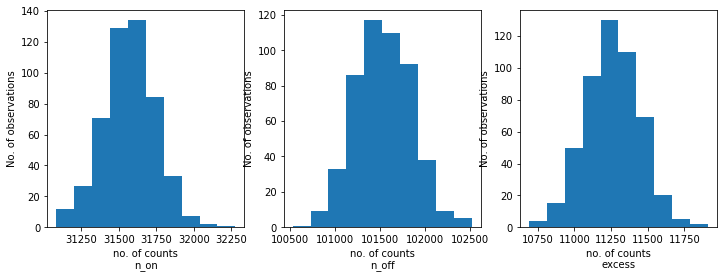

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 2min 12s, sys: 214 ms, total: 2min 13s
Wall time: 2min 13s


In [15]:
results

[{'index': 2.2277014890350046,
  'amplitude': 1.2361699597883032e-12,
  'lambda_': 0.8771913199199592},
 {'index': 2.256141939366527,
  'amplitude': 1.1592170018498003e-12,
  'lambda_': 0.9123668648988691},
 {'index': 2.2673187750347403,
  'amplitude': 1.164801174921426e-12,
  'lambda_': 0.9770119045607368},
 {'index': 2.204478662830411,
  'amplitude': 1.3707461586045393e-12,
  'lambda_': 1.1180169016820818},
 {'index': 2.162123369183518,
  'amplitude': 1.4941489960213284e-12,
  'lambda_': 1.149481269135693},
 {'index': 2.16195812798937,
  'amplitude': 1.4656723948010833e-12,
  'lambda_': 1.1630444804572702},
 {'index': 2.247214118644901,
  'amplitude': 1.2213017496185367e-12,
  'lambda_': 0.9388338034853017},
 {'index': 2.221837157834904,
  'amplitude': 1.2866730136361347e-12,
  'lambda_': 0.9936044166833219},
 {'index': 2.213182287647928,
  'amplitude': 1.2811266719895797e-12,
  'lambda_': 0.983066055358285},
 {'index': 2.2502531549190885,
  'amplitude': 1.1879297852981216e-12,
  'la

index: 2.2169101964134987 += 0.03217920184219841


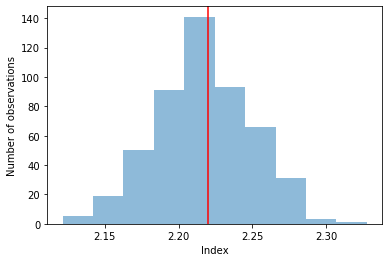

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.3023691738455963e-12 += 1.0067000624138924e-13


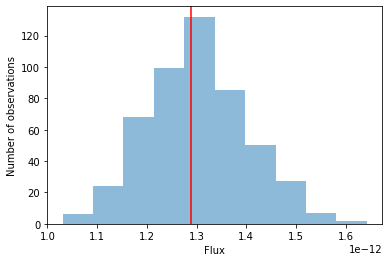

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 1.0079008712540156 += 0.08030988126769599


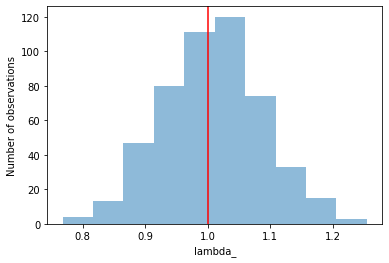

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")